In [27]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
def extract_features(audio_path, sr=22050):
    y, _ = librosa.load(audio_path, sr=sr)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)

    # Pitch (F0)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    f0 = [np.max(pitches[:, i]) if np.max(magnitudes[:, i]) > 0 else 0 for i in range(pitches.shape[1])]
    f0_mean = np.mean([pitch for pitch in f0 if pitch > 0])
    f0_std = np.std([pitch for pitch in f0 if pitch > 0])

    # Spectral Centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroids)
    spectral_centroid_std = np.std(spectral_centroids)

    # Pack features into a flat array
    features = np.concatenate([mfccs_mean, mfccs_std, [f0_mean, f0_std, spectral_centroid_mean, spectral_centroid_std]])
    
    return features


In [19]:
data_dir = 'Multi_Class_Classification'
folders = ['frustrated', 'delighted', 'dysregulated', 'request', 'selftalk']

# Initialize lists to store features and labels
feature_list = []
labels = []

# Loop over each folder to load and label data
for label in folders:
    folder_path = os.path.join(data_dir, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):  # Assuming audio files are .wav
            file_path = os.path.join(folder_path, file_name)
            features = extract_features(file_path)
            feature_list.append(features)
            labels.append(label)

# Convert to arrays
X = np.array(feature_list)
y = np.array(labels)

c:\Users\Meghal\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1905
  warnings.warn(
c:\Users\Meghal\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1816
  warnings.warn(


In [20]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.622852233676976
              precision    recall  f1-score   support

   delighted       0.58      0.50      0.54       257
dysregulated       0.73      0.58      0.64       132
  frustrated       0.71      0.67      0.69       326
     request       0.52      0.17      0.26        80
    selftalk       0.57      0.78      0.66       369

    accuracy                           0.62      1164
   macro avg       0.62      0.54      0.56      1164
weighted avg       0.63      0.62      0.61      1164



In [23]:
feature_names = [f'mfcc_mean_{i}' for i in range(13)] + [f'mfcc_std_{i}' for i in range(13)] + ['f0_mean', 'f0_std', 'spectral_centroid_mean', 'spectral_centroid_std']
df = pd.DataFrame(feature_list, columns=feature_names)
df['label'] = labels

In [24]:
df['label'] = LabelEncoder().fit_transform(df['label'])

In [25]:
print("Statistical Summary:")
print(df.groupby('label').describe())

Statistical Summary:
      mfcc_mean_0                                                             \
            count        mean        std         min         25%         50%   
label                                                                          
0          1272.0 -257.271441  75.700477 -503.612305 -307.789307 -253.125519   
1           704.0 -250.857364  89.737777 -483.234680 -315.903053 -247.279999   
2          1536.0 -253.291649  74.380524 -471.348114 -301.261414 -253.090553   
3           419.0 -264.824591  71.888775 -465.577209 -317.106491 -256.715546   
4          1885.0 -238.258324  70.160219 -478.137146 -285.486725 -231.966599   

                             mfcc_mean_1              ...  \
              75%        max       count        mean  ...   
label                                                 ...   
0     -199.233524 -83.732986      1272.0  110.913158  ...   
1     -176.332424 -77.964706       704.0  122.228014  ...   
2     -205.438419 -43.792938     

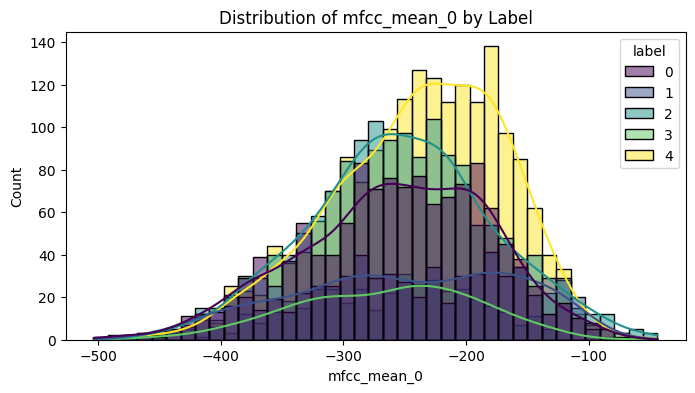

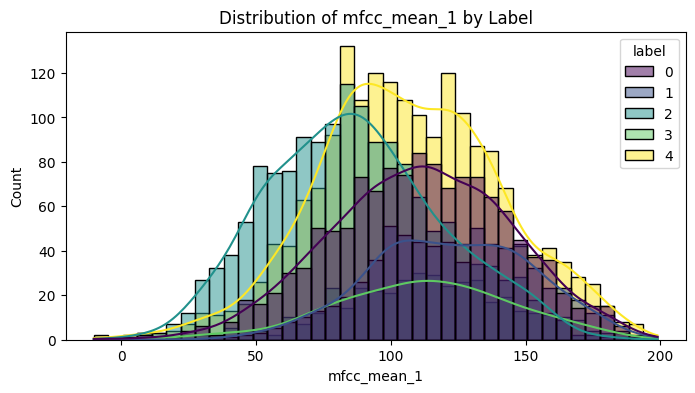

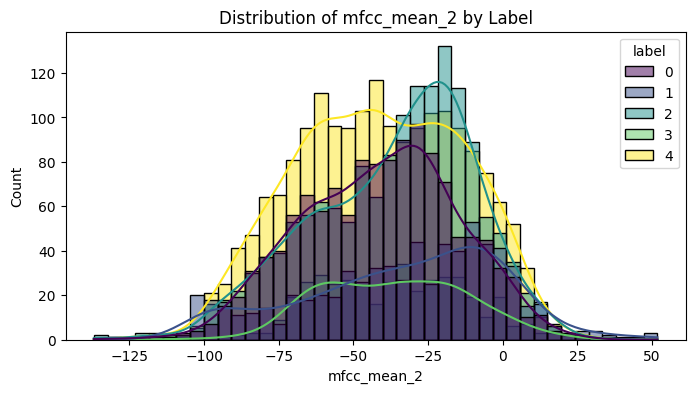

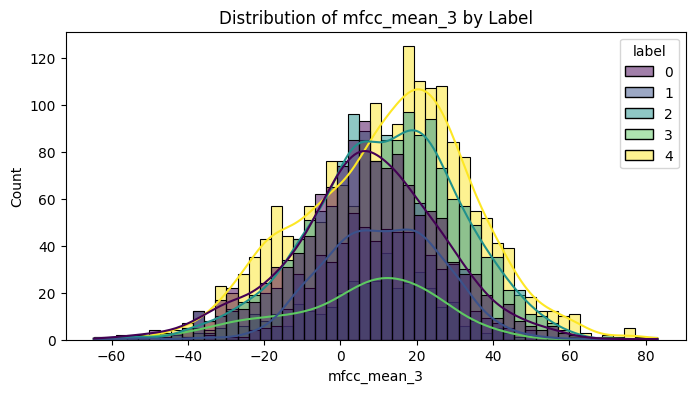

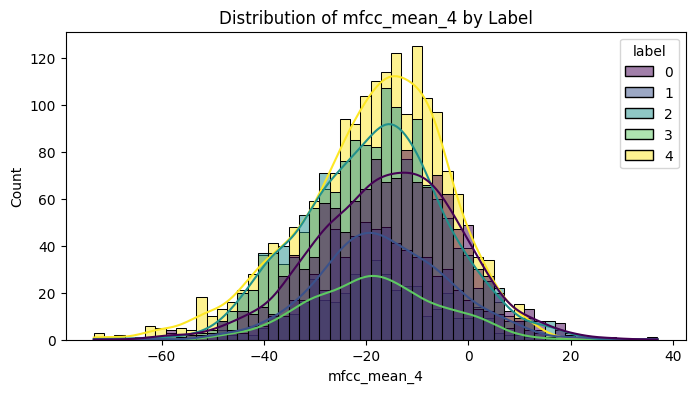

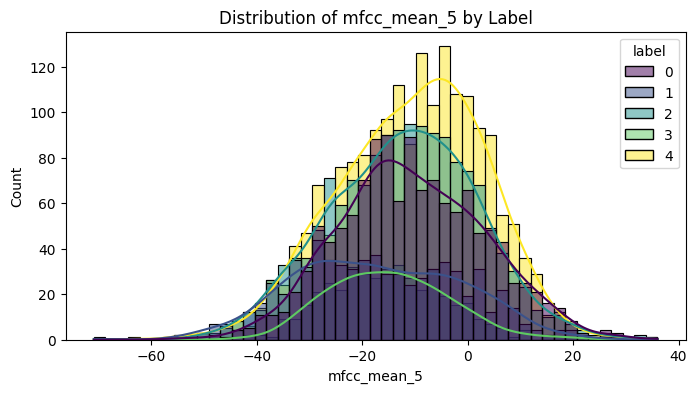

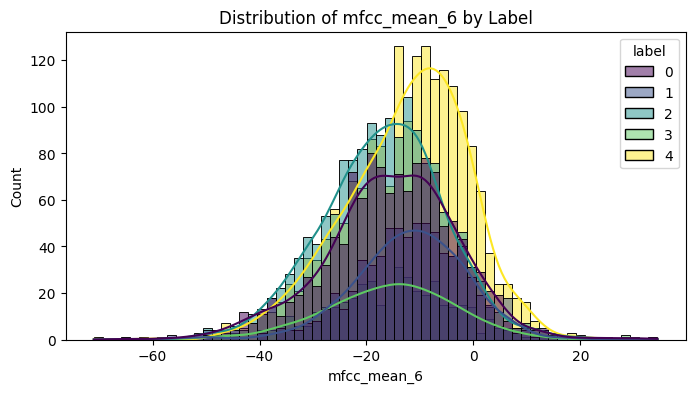

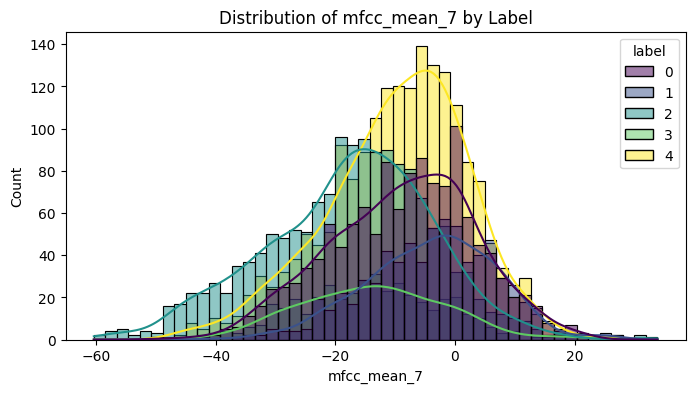

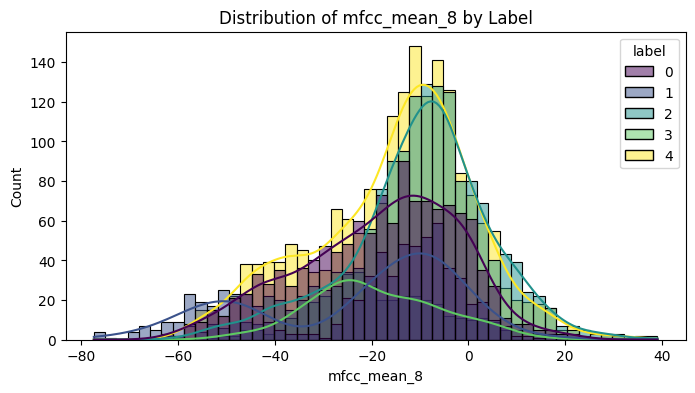

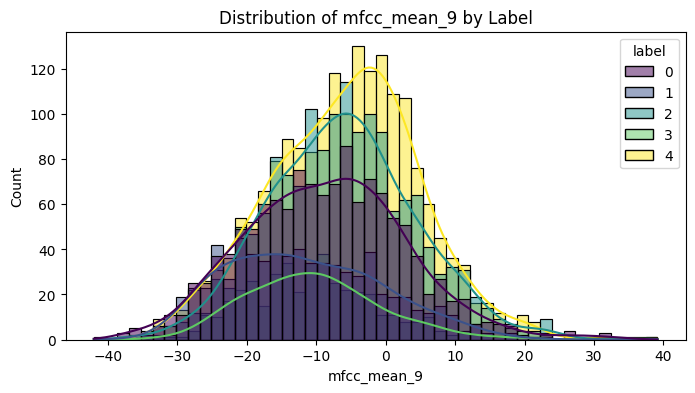

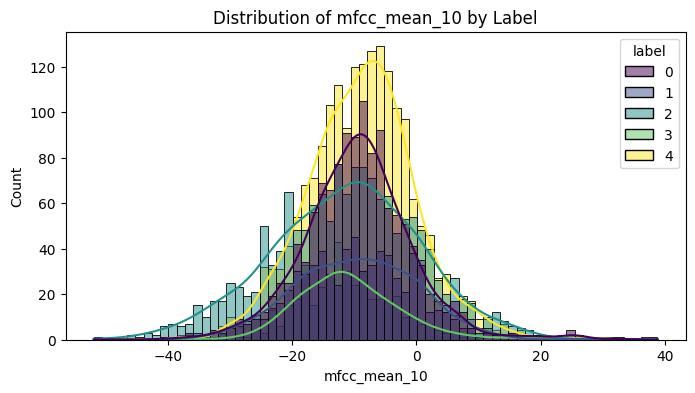

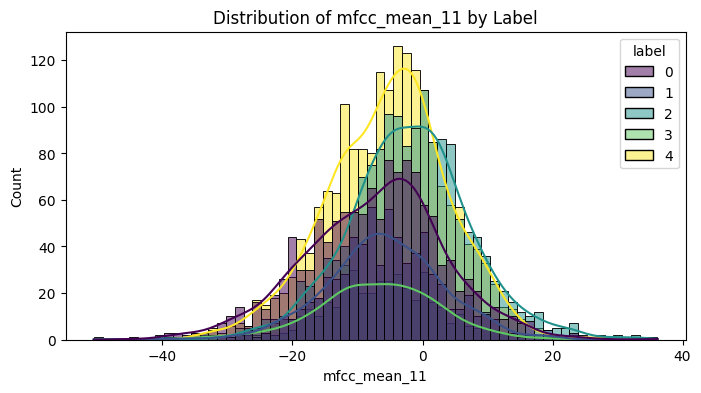

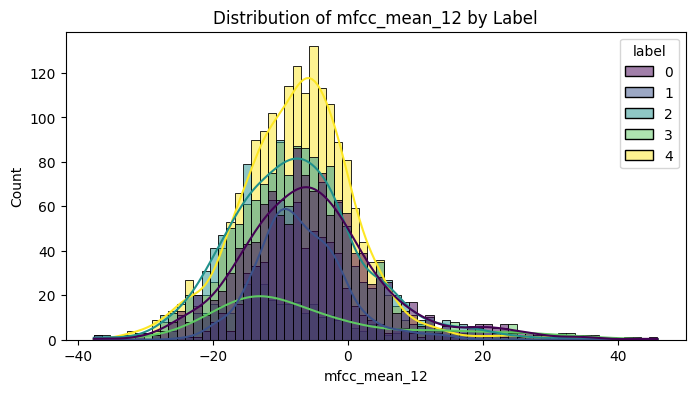

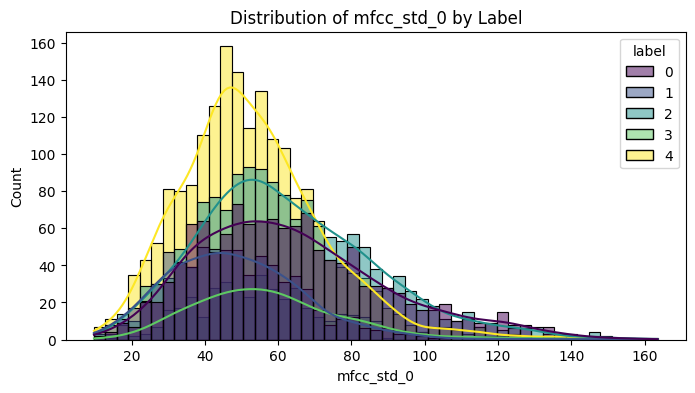

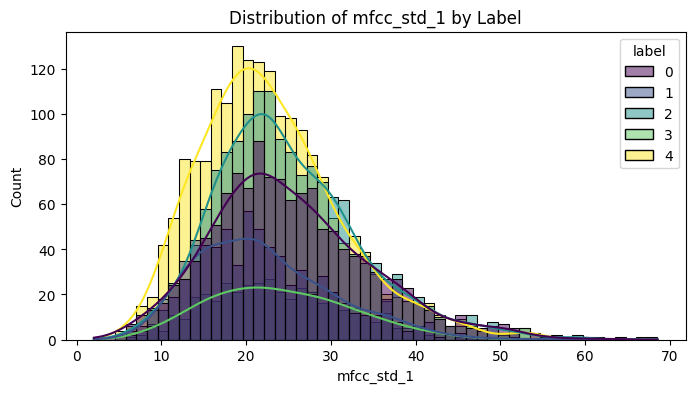

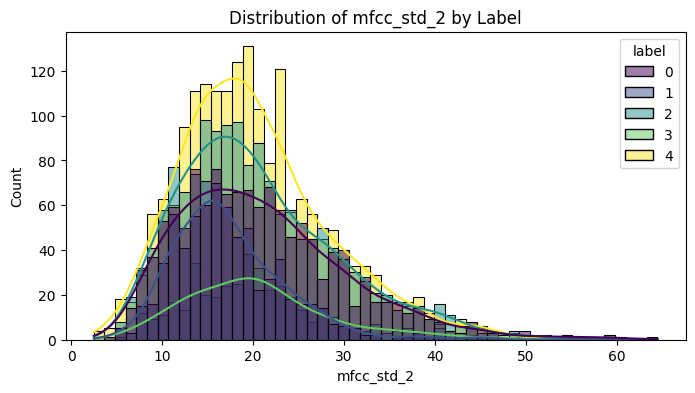

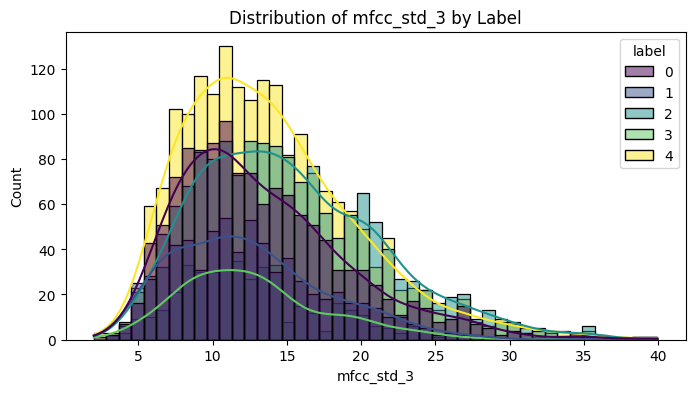

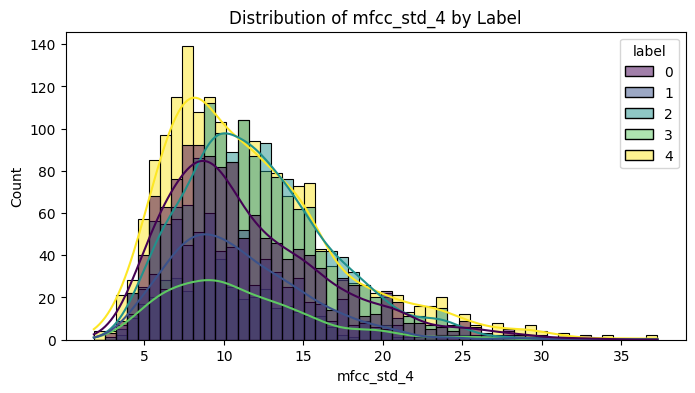

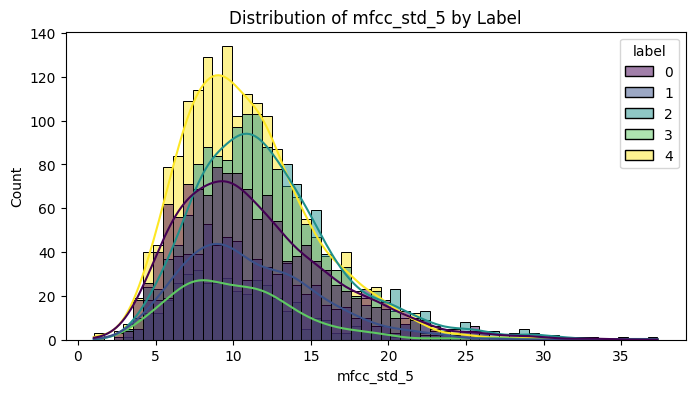

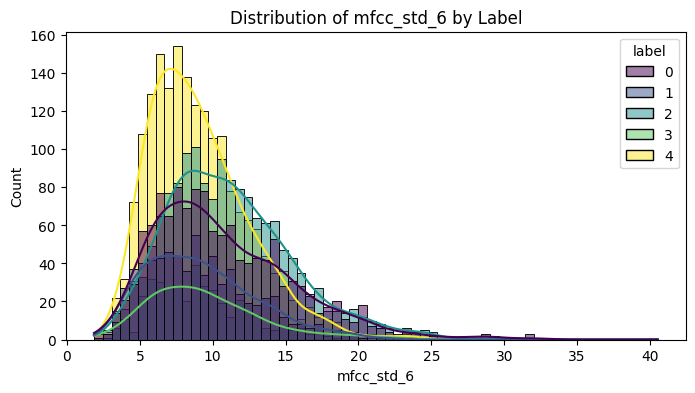

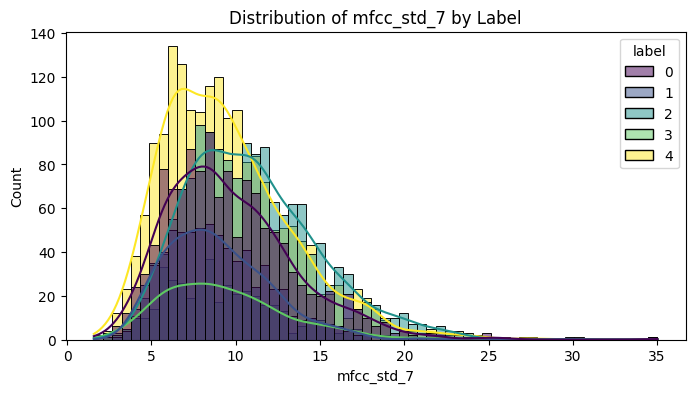

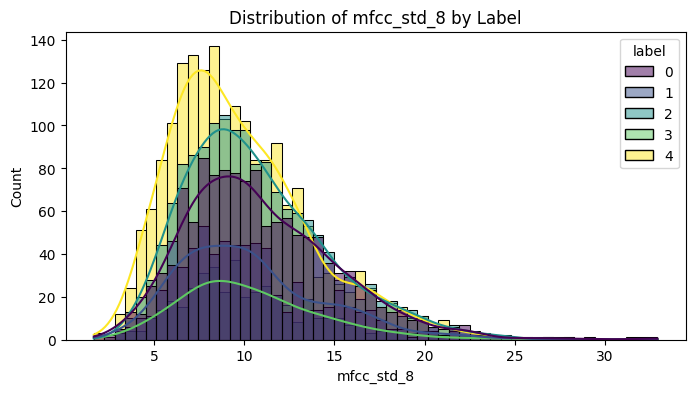

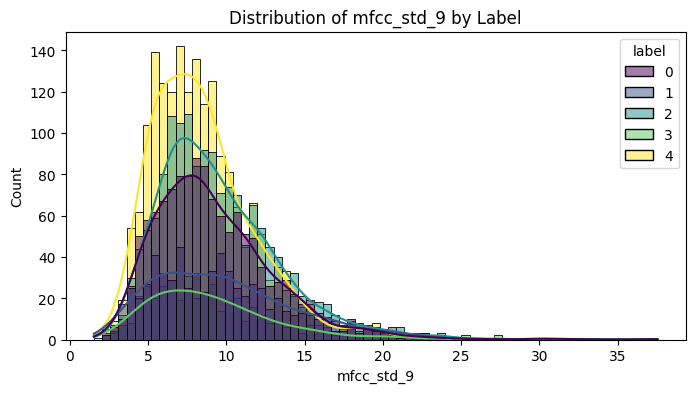

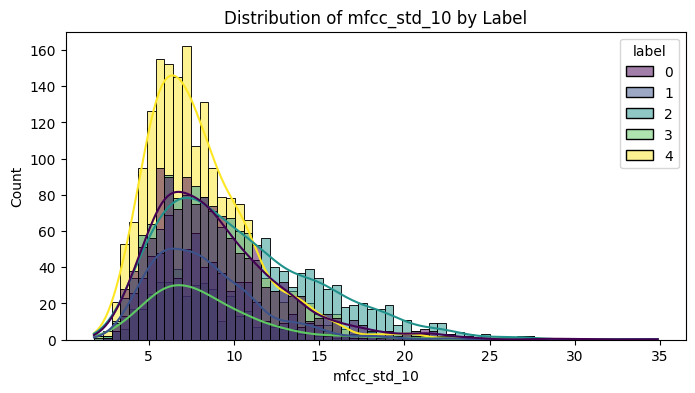

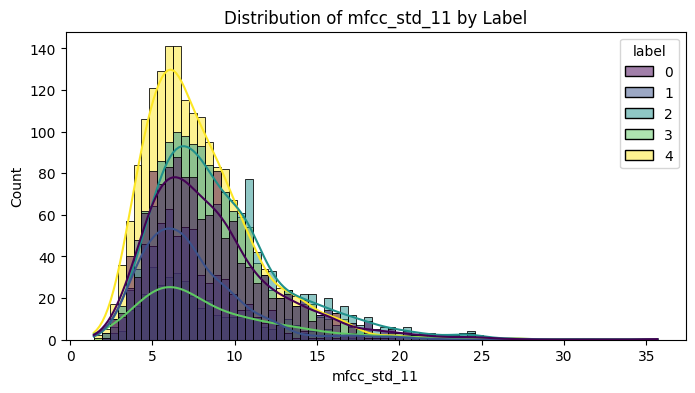

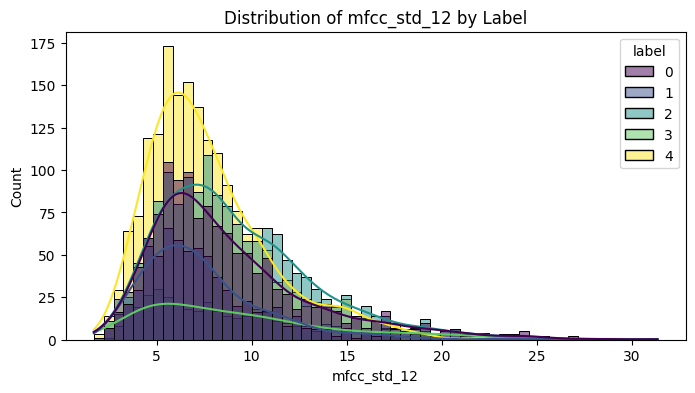

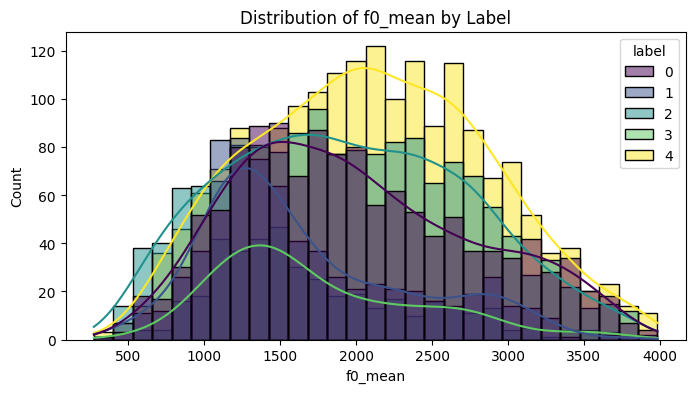

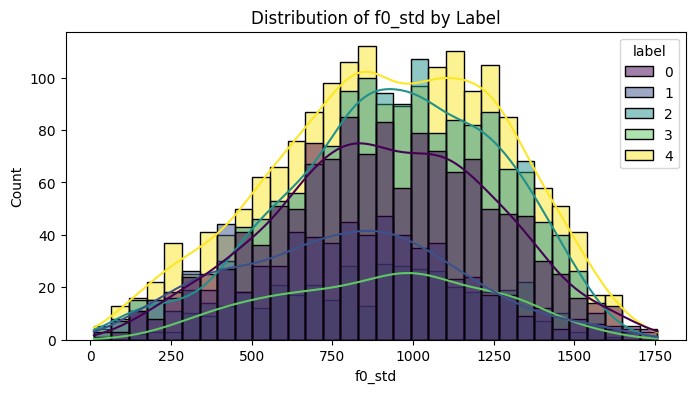

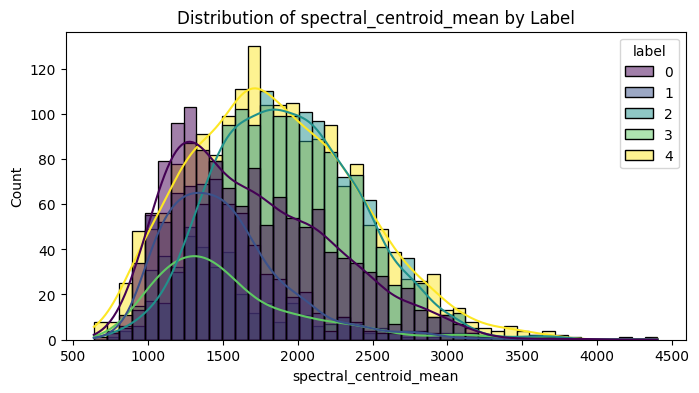

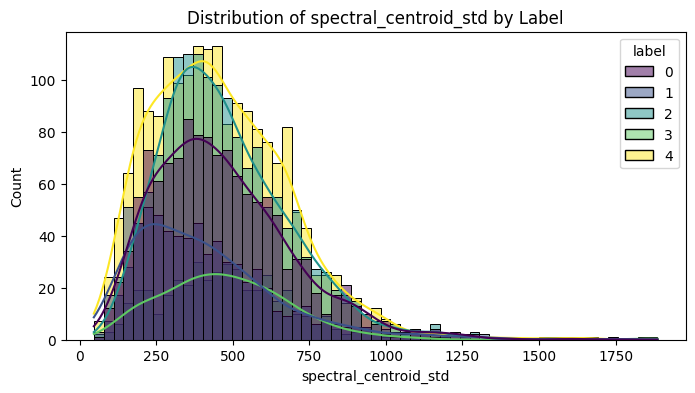

In [26]:
for feature in feature_names:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue='label', kde=True, palette="viridis")
    plt.title(f'Distribution of {feature} by Label')
    plt.show()

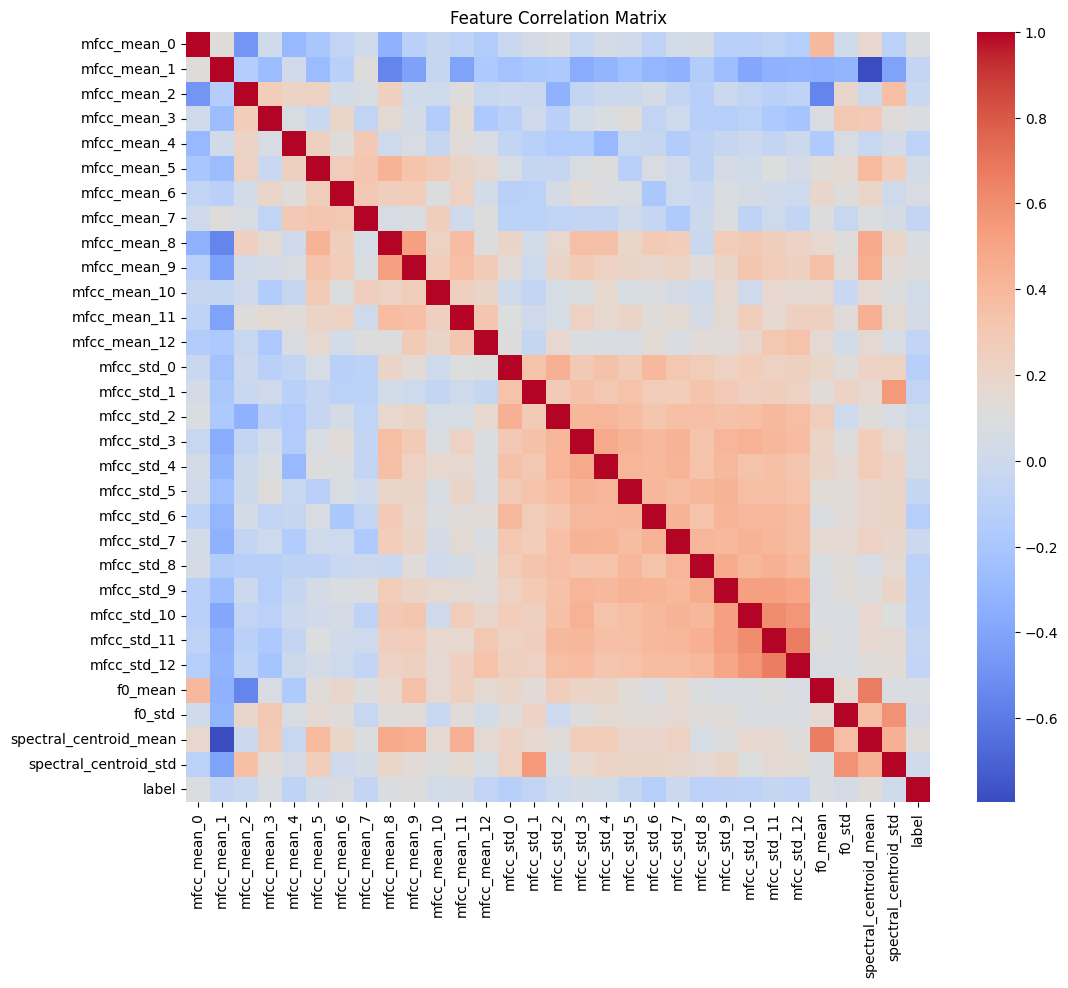

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

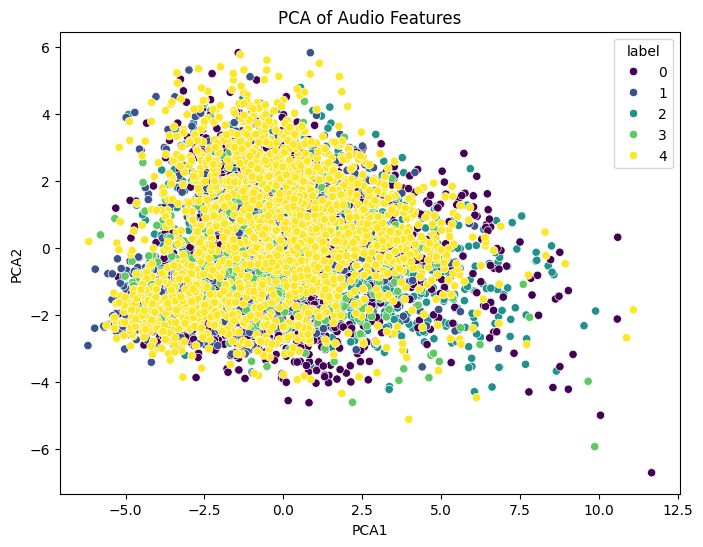

In [28]:
X_scaled = StandardScaler().fit_transform(df[feature_names])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['label'] = df['label']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_pca, palette="viridis")
plt.title("PCA of Audio Features")
plt.show()

c:\Users\Meghal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


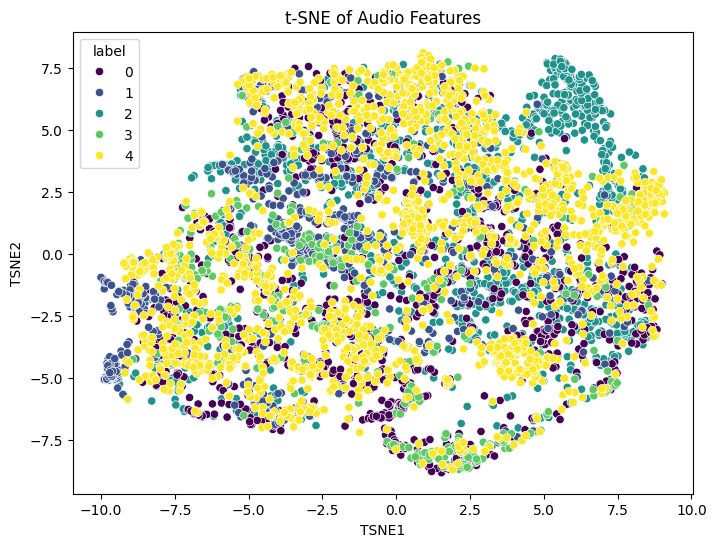

In [29]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = df['label']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=df_tsne, palette="viridis")
plt.title("t-SNE of Audio Features")
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['label'], test_size=0.3, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6034383954154727
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       379
           1       0.70      0.55      0.62       205
           2       0.71      0.64      0.68       495
           3       0.53      0.14      0.22       124
           4       0.54      0.76      0.63       542

    accuracy                           0.60      1745
   macro avg       0.61      0.52      0.53      1745
weighted avg       0.61      0.60      0.59      1745

Confusion Matrix:
[[193  10  41  10 125]
 [ 14 112  33   0  46]
 [ 39  14 319   2 121]
 [ 28   8  18  17  53]
 [ 75  15  37   3 412]]
